In [144]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tsfresh import extract_features
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from keras.models import Sequential
import pickle
from time import time
from tsfresh.feature_extraction import MinimalFCParameters
import umap.umap_ as umap
from sklearn.decomposition import PCA


# PART 1

## Q1: Exploratory Data Analysis 

### 1.1 - PTB DATASET

#### 1.1.1 - import data

In [92]:
# step 1 - take data
PTB_train = pd.read_csv("./datasets/ptbdb_train.csv")
PTB_test = pd.read_csv("./datasets/ptbdb_test.csv")
# step 2 - add column names
column_names = [f"time{i}" for i in range(187)] + ["Class"]
PTB_train.columns = column_names
PTB_test.columns = column_names

#### 1.1.2 - explore dataset

In [38]:
# step 1 - basic dataset exploration
print("Dataset dimensions:", PTB_train.shape)
print('--------------------------------')
print("Number of missing values:")
print(PTB_train.isnull().sum())

Dataset dimensions: (11640, 188)
--------------------------------
Number of missing values:
time0      0
time1      0
time2      0
time3      0
time4      0
          ..
time183    0
time184    0
time185    0
time186    0
Class      0
Length: 188, dtype: int64


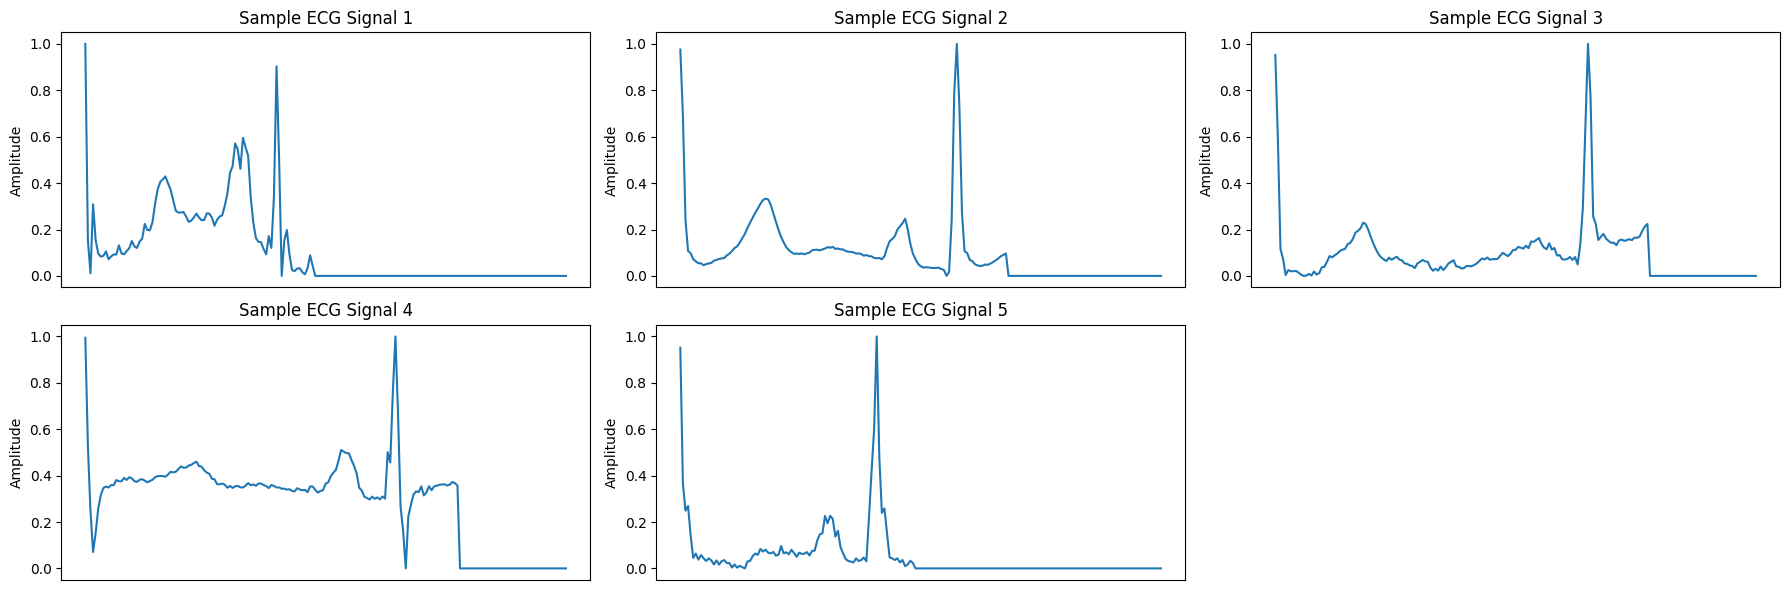

In [39]:
# step 2 - data Visualization
plt.figure(figsize=(18, 6))
for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.lineplot(data=PTB_train.iloc[i, :-1])
    plt.title(f"Sample ECG Signal {i+1}")
    plt.ylabel("Amplitude")
    plt.xticks([])
plt.tight_layout()
plt.show()

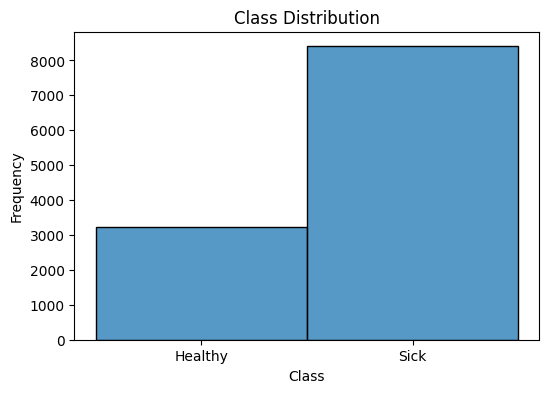

In [40]:
# step 3 - class distribution
plt.figure(figsize=(6, 4))
sns.histplot(data=PTB_train, x="Class", bins=2, edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution")
plt.xticks([0.25, 0.75], ['Healthy', 'Sick'])
plt.show()

#### 1.1.3 - X/Y

In [122]:
PTB_X_train = PTB_train.iloc[:,:-1]
PTB_y_train = PTB_train.iloc[:,-1]
PTB_X_test = PTB_test.iloc[:,:-1]
PTB_y_test = PTB_test.iloc[:,-1]

PTB_X_train, PTB_X_val, PTB_y_train, PTB_y_val = train_test_split(PTB_X_train, PTB_y_train, test_size=0.15, shuffle=True)

#### 1.1.4 - class weights

In [123]:
PTB_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(PTB_y_train), y=PTB_y_train)
PTB_class_weight_dict = dict(zip(np.unique(PTB_y_train), PTB_class_weights))

### 1.2 - MIT-BIH DATASET

#### 1.2.1 - import data

In [67]:
# step 1 - take data
MIT_train = pd.read_csv("./datasets/mitbih_train.csv")
MIT_test = pd.read_csv("./datasets/mitbih_test.csv")
# step 2 - add column names
column_names = [f"time{i}" for i in range(187)] + ["Class"]
MIT_train.columns = column_names
MIT_test.columns = column_names

#### 1.2.2 - explore dataset

In [44]:
# step 1 - basic dataset exploration
print("Dataset dimensions:", MIT_train.shape)
print('--------------------------------')
print("Number of missing values:")
print(MIT_train.isnull().sum())

Dataset dimensions: (87553, 188)
--------------------------------
Number of missing values:
time0      0
time1      0
time2      0
time3      0
time4      0
          ..
time183    0
time184    0
time185    0
time186    0
Class      0
Length: 188, dtype: int64


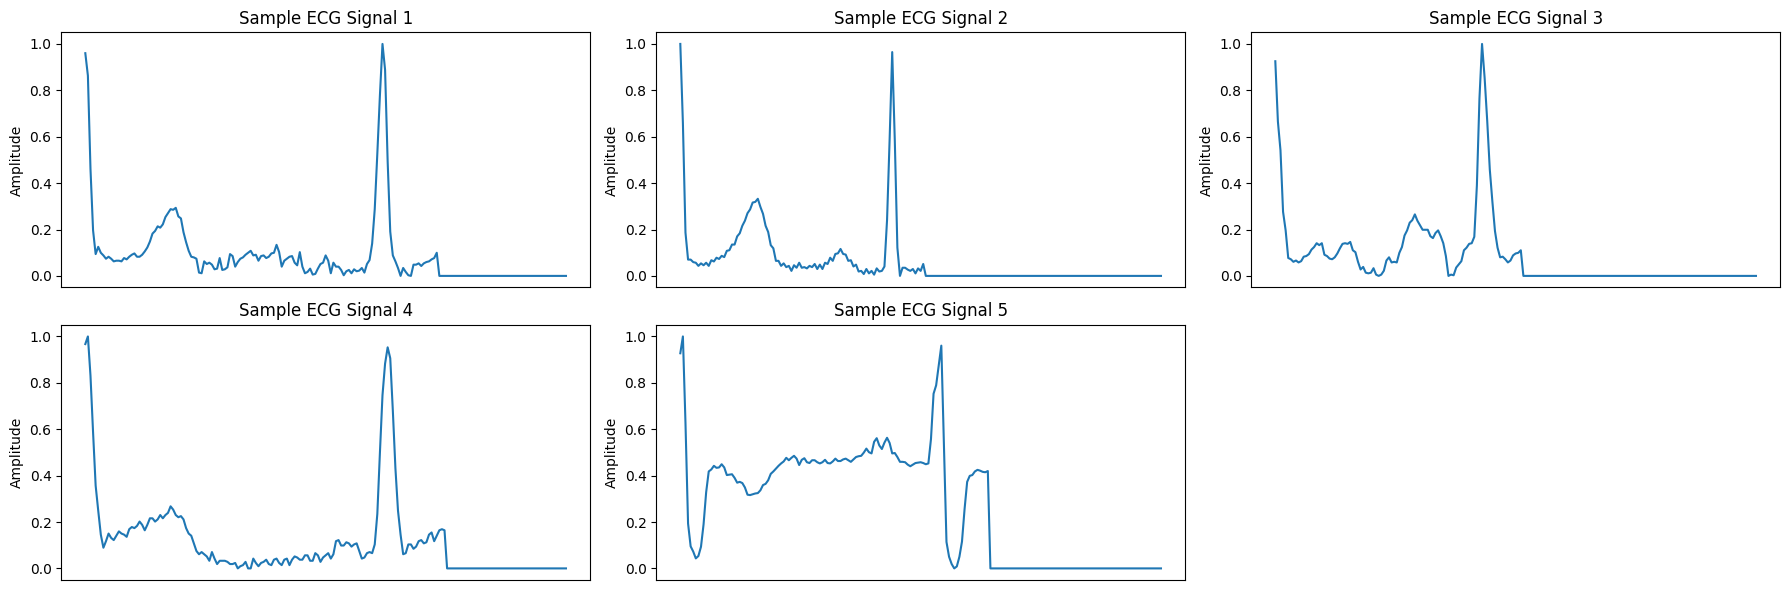

In [45]:
# step 2 - data Visualization
plt.figure(figsize=(18, 6))
for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.lineplot(data=MIT_train.iloc[i, :-1])
    plt.title(f"Sample ECG Signal {i+1}")
    plt.ylabel("Amplitude")
    plt.xticks([])
plt.tight_layout()
plt.show()

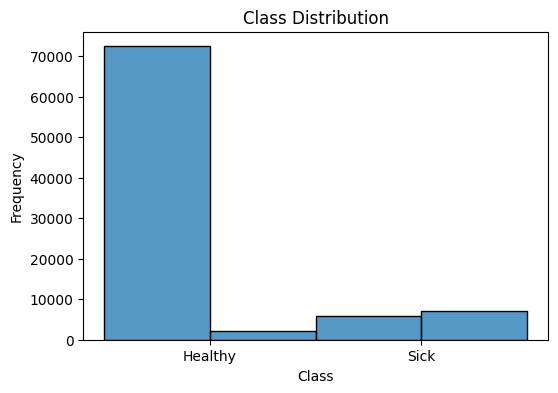

In [46]:
# step 3 - class distribution
plt.figure(figsize=(6, 4))
sns.histplot(data=MIT_train, x="Class", bins=4, edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution")
plt.xticks([1, 3], ['Healthy', 'Sick'])
plt.show()

#### 1.2.3 - X/Y

In [47]:
MIT_X_train = MIT_train.iloc[:,:-1]
MIT_y_train = MIT_train.iloc[:,-1]
MIT_X_test = MIT_test.iloc[:,:-1]
MIT_y_test = MIT_test.iloc[:,-1]

MIT_X_train, MIT_X_val, MIT_y_train, MIT_y_val = train_test_split(MIT_X_train, MIT_y_train, test_size=0.15, shuffle=True)

#### 1.2.4 - class weights

In [48]:
MIT_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(MIT_y_train), y=MIT_y_train)
MIT_class_weight_dict = dict(zip(np.unique(MIT_y_train), MIT_class_weights))

## Q2

### 2.1 - no features

In [49]:
# METHOD 1: Random Forest classifier
PTB_sample_weights = np.array([PTB_class_weights[int(i)] for i in PTB_y_train])
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(PTB_X_train, PTB_y_train, sample_weight=PTB_sample_weights)
rf_pred = rf_classifier.predict(PTB_X_test)
rf_bal_accuracy = balanced_accuracy_score(PTB_y_test, rf_pred)

# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(PTB_X_train, PTB_y_train, sample_weight=PTB_sample_weights)
lr_pred = lr_classifier.predict(PTB_X_test)
lr_bal_accuracy =  balanced_accuracy_score(PTB_y_test, rf_pred)

print("Random Forest Classifier balanced accuracy score:", rf_bal_accuracy)
print('--------------------------------')
print("Logistic Regressor balanced accuracy score:", lr_bal_accuracy)

Random Forest Classifier balanced accuracy score: 0.949974564535426
--------------------------------
Logistic Regressor balanced accuracy score: 0.949974564535426


### 2.2 - features

In [53]:
# step 0 - add IDs
PTB_train_copy = PTB_train.copy()
PTB_test_copy = PTB_test.copy()
unique_ids = np.arange(PTB_train_copy.shape[0]) 
PTB_train_copy.insert(0, 'unique_id', unique_ids)
unique_ids = np.arange(PTB_test_copy.shape[0]) 
PTB_test_copy.insert(0, 'unique_id', unique_ids)

# step 1 - split
PTB_X_train2 = PTB_train_copy.iloc[:,:-1]
PTB_y_train2 = PTB_train_copy.iloc[:,-1]
PTB_X_test2 = PTB_test_copy.iloc[:,:-1]
PTB_y_test2 = PTB_test_copy.iloc[:,-1]

# step 2 - extract features
X_train_features = extract_features(PTB_X_train2, column_id='unique_id', default_fc_parameters=MinimalFCParameters())
X_test_features = extract_features(PTB_X_test2, column_id='unique_id', default_fc_parameters=MinimalFCParameters())

# step 3 - methods
# METHOD 1: Random Forest classifier
PTB_sample_weights2 = np.array([PTB_class_weights[int(i)] for i in PTB_y_train2])
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_features, PTB_y_train2, sample_weight=PTB_sample_weights2)
rf_pred = rf_classifier.predict(X_test_features)
rf_bal_accuracy = balanced_accuracy_score(PTB_y_test2, rf_pred)

# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train_features, PTB_y_train2, sample_weight=PTB_sample_weights2)
lr_pred = lr_classifier.predict(X_test_features)
lr_bal_accuracy =  balanced_accuracy_score(PTB_y_test2, rf_pred)

print("Random Forest Classifier balanced accuracy score:", rf_bal_accuracy)
print('--------------------------------')
print("Logistic Regressor balanced accuracy score:", lr_bal_accuracy)

Feature Extraction: 100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


Random Forest Classifier balanced accuracy score: 0.9506899369765711
--------------------------------
Logistic Regressor balanced accuracy score: 0.9506899369765711


/home/ilboglions/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Q3

In [68]:
M_TRAIN = PTB_X_train.shape[0]
M_TEST = PTB_X_test.shape[0]
N = 1
T = PTB_X_train.shape[1]
BATCH = 64
EPOCH = 60
LR = 1e-3 

In [69]:
model = Sequential()
model.add(LSTM(50, input_shape=(T, N)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start = time()
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
'''History = model.fit(PTB_X_train.values, PTB_y_train.values, epochs=EPOCH, batch_size=BATCH, 
                    validation_data = (PTB_X_val.values, PTB_y_val.values),
                    callbacks=[early_stopping, reduce_lr], 
                    class_weight=PTB_class_weight_dict)

model.save('models/lstm_model.keras')
with open('models/lstm_history.pkl', 'wb') as file:
    pickle.dump(History.history, file)'''


with open('models/lstm_history.pkl', 'rb') as file:
    History = pickle.load(file)
model = keras.models.load_model('models/lstm_model.keras')

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Epoch 1/60


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.5134 - loss: 0.6841 - val_accuracy: 0.6867 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 2/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6196 - loss: 0.6161 - val_accuracy: 0.6271 - val_loss: 0.5960 - learning_rate: 0.0010
Epoch 3/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6708 - loss: 0.5884 - val_accuracy: 0.6581 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 4/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6970 - loss: 0.5473 - val_accuracy: 0.6896 - val_loss: 0.5678 - learning_rate: 2.0000e-04
Epoch 5/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6974 - loss: 0.5347 - val_accuracy: 0.6924 - val_loss: 0.5715 - learning_rate: 2.0000e-04
Epoch 6/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7171 - loss: 0.5245 - val_accuracy: 0.7056 - val_loss: 0.5356 - learning_rate: 2.0000e-04
Epoch 7/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7206 - 

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
-----------------------------------------------------------------
Test balanced accuracy = 81.1324%
-----------------------------------------------------------------


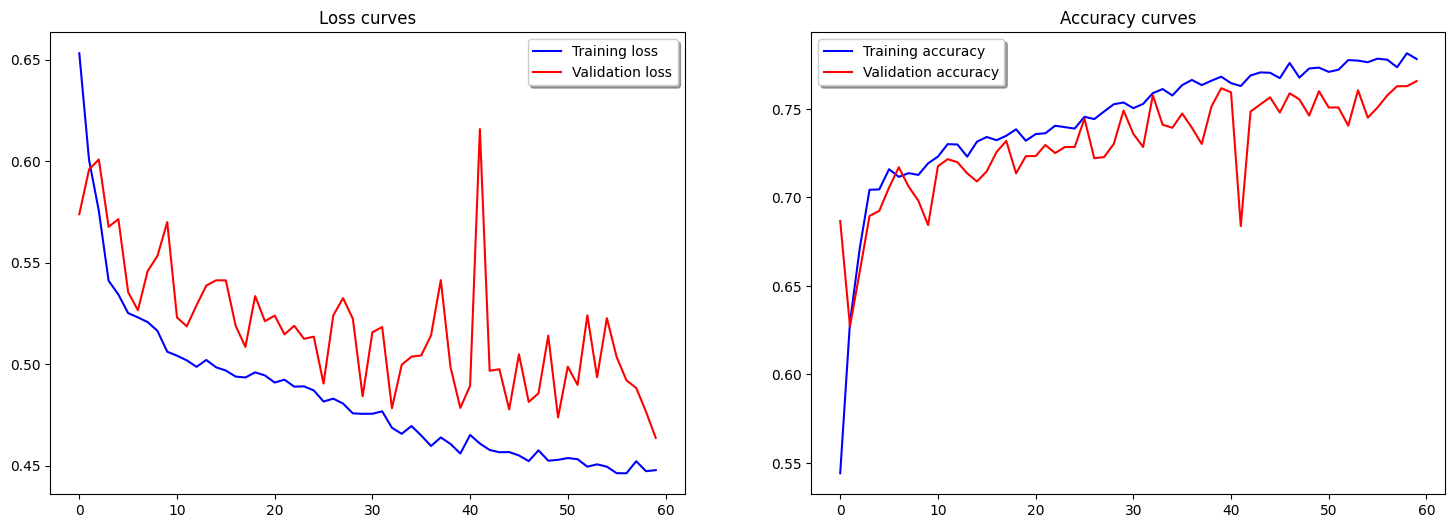

In [70]:

PTB_y_pred = model.predict(PTB_X_test[:M_TEST])
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History['loss'], color='b', label='Training loss')
axs[0].plot(History['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [71]:
bidirectional_model = Sequential()
bidirectional_model.add(Bidirectional(LSTM(50), input_shape=(T, N)))
bidirectional_model.add(Dense(1, activation='sigmoid')) 

bidirectional_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

'''History = bidirectional_model.fit(PTB_X_train.values, PTB_y_train.values, epochs=EPOCH, batch_size=BATCH, 
                                  validation_data=[PTB_X_val.values, PTB_y_val.values], 
                                  callbacks=[early_stopping, reduce_lr],
                                  class_weight=PTB_class_weight_dict)

bidirectional_model.save('models/bidirectional_model.keras')
with open('models/bidir_history.pkl', 'wb') as file:
    pickle.dump(History.history, file)'''

with open('models/bidir_history.pkl', 'rb') as file:
    History = pickle.load(file)

bidirectional_model = keras.models.load_model('models/bidirectional_model.keras')


print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Epoch 1/60


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.6358 - loss: 0.6618 - val_accuracy: 0.6953 - val_loss: 0.5809 - learning_rate: 0.0010
Epoch 2/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.7239 - loss: 0.5295 - val_accuracy: 0.7302 - val_loss: 0.4924 - learning_rate: 0.0010
Epoch 3/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7438 - loss: 0.4784 - val_accuracy: 0.7532 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 4/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7659 - loss: 0.4583 - val_accuracy: 0.7698 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 5/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7797 - loss: 0.4505 - val_accuracy: 0.7812 - val_loss: 0.4561 - learning_rate: 0.0010
Epoch 6/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.7857 - loss: 0.4322 - val_accuracy: 0.7892 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 7/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7878 - loss: 0

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
-----------------------------------------------------------------
Test balanced accuracy = 86.3764%
-----------------------------------------------------------------


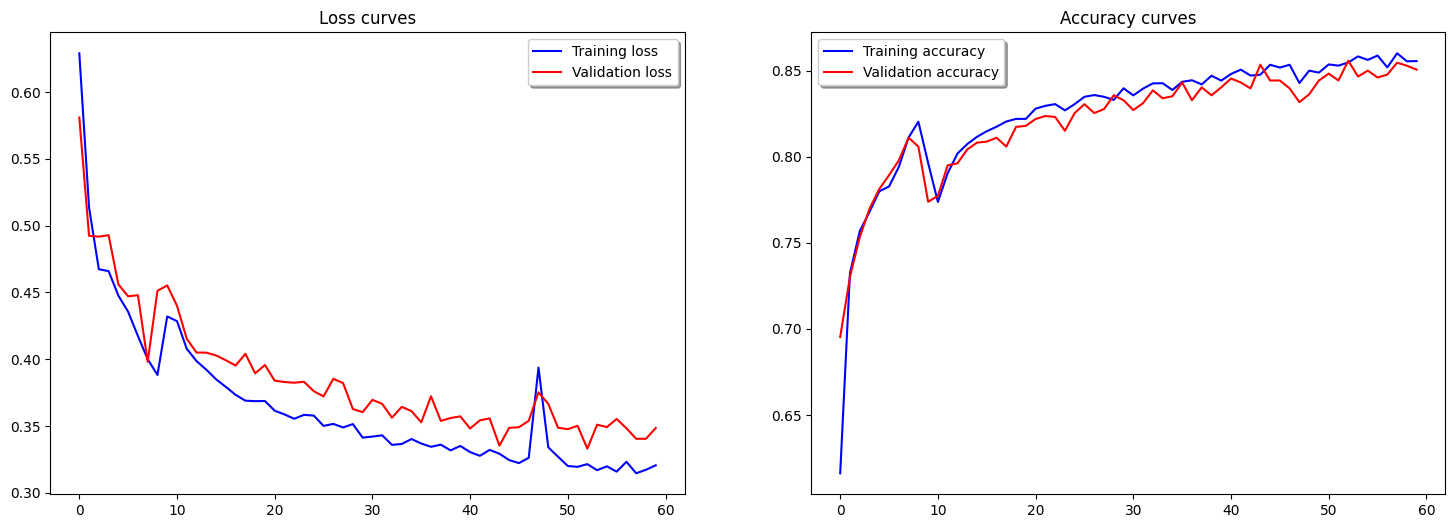

In [72]:
PTB_y_pred = bidirectional_model.predict(PTB_X_test[:M_TEST])
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History['loss'], color='b', label='Training loss')
axs[0].plot(History['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

## Q4

In [73]:
# step 1 - adapt data to pytorch CNN
X_train_tensor = torch.tensor(PTB_X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(PTB_y_train, dtype=torch.long)
X_test_tensor = torch.tensor(PTB_X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(PTB_y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# step 2 -  Vanilla CNN model
class VanillaCNN(nn.Module):
    def __init__(self, input_length):
        super(VanillaCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (input_length // 4), 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# step 3 - Residual CNN model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResidualCNN(nn.Module):
    def __init__(self, input_length):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 3)
        self.layer2 = self.make_layer(64, 128, 3)
        self.layer3 = self.make_layer(128, 256, 3)
        self.fc = nn.Linear(256 * 47, 2)


    def make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# step 4 - train loop
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    bal = balanced_accuracy_score(all_labels,all_preds)
    
    return epoch_loss, bal

# step 5 - test loop
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    bal = balanced_accuracy_score(all_labels,all_preds)
    
    return epoch_loss, bal



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_length = 187
vanilla_model = VanillaCNN(input_length).to(device)
residual_model = ResidualCNN(input_length).to(device)
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=learning_rate)
residual_optimizer = optim.Adam(residual_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_balanced_accuracy_score = train(vanilla_model, train_loader, vanilla_optimizer, criterion, device)
    test_loss, test_balanced_accuracy_score = evaluate(vanilla_model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Vanilla CNN - Train Loss: {train_loss:.4f}, Train balanced accuracy score: {train_balanced_accuracy_score:.4f}, Test Loss: {test_loss:.4f}, Test balanced accuracy score: {test_balanced_accuracy_score:.4f}")
for epoch in range(num_epochs):
    train_loss, train_balanced_accuracy_score = train(residual_model, train_loader, residual_optimizer, criterion, device)
    test_loss, test_balanced_accuracy_score = evaluate(residual_model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Residual CNN - Train Loss: {train_loss:.4f}, Train balanced accuracy score: {train_balanced_accuracy_score:.4f}, Test Loss: {test_loss:.4f}, Test balanced accuracy score: {test_balanced_accuracy_score:.4f}")


Epoch [1/10], Vanilla CNN - Train Loss: 0.4498, Train balanced accuracy score: 0.6769, Test Loss: 0.3842, Test balanced accuracy score: 0.7048
Epoch [2/10], Vanilla CNN - Train Loss: 0.3561, Train balanced accuracy score: 0.7928, Test Loss: 0.3319, Test balanced accuracy score: 0.8119
Epoch [3/10], Vanilla CNN - Train Loss: 0.3098, Train balanced accuracy score: 0.8301, Test Loss: 0.3137, Test balanced accuracy score: 0.8380
Epoch [4/10], Vanilla CNN - Train Loss: 0.2655, Train balanced accuracy score: 0.8549, Test Loss: 0.2568, Test balanced accuracy score: 0.8579
Epoch [5/10], Vanilla CNN - Train Loss: 0.2298, Train balanced accuracy score: 0.8849, Test Loss: 0.2195, Test balanced accuracy score: 0.9003
Epoch [6/10], Vanilla CNN - Train Loss: 0.1924, Train balanced accuracy score: 0.9044, Test Loss: 0.1965, Test balanced accuracy score: 0.9116
Epoch [7/10], Vanilla CNN - Train Loss: 0.1688, Train balanced accuracy score: 0.9166, Test Loss: 0.1825, Test balanced accuracy score: 0.9227

## Q5

In [74]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)



input_shape = (187, 1)
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 2
mlp_units = [128]
dropout = 0.25
mlp_dropout = 0.25
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

'''model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=50, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          callbacks=[early_stopping],
          class_weight=PTB_class_weight_dict)
model.save('models/transformers_model.keras')'''
model = keras.models.load_model('models/transformers_model.keras')

PTB_y_pred = model.predict(PTB_X_test.values)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test.values, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step
-----------------------------------------------------------------
Test balanced accuracy = 94.2933%
-----------------------------------------------------------------


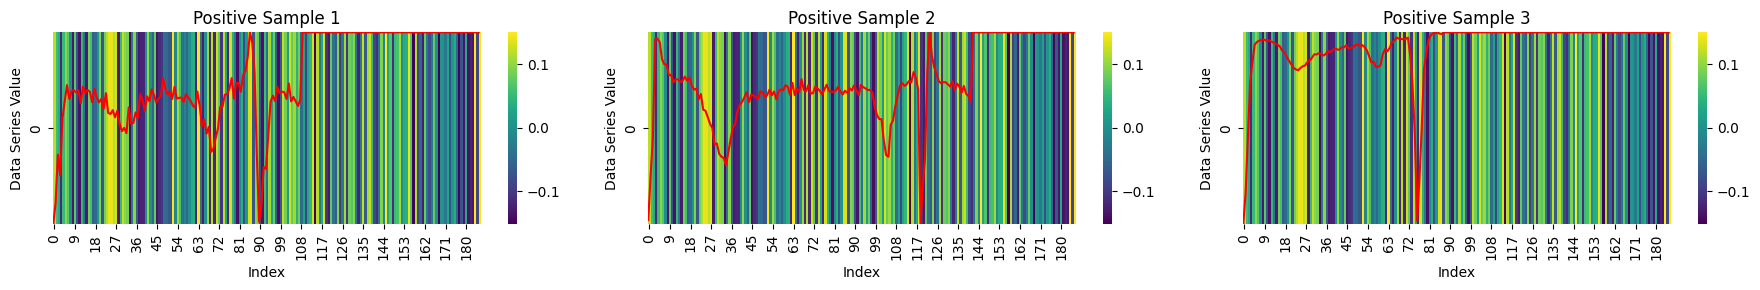

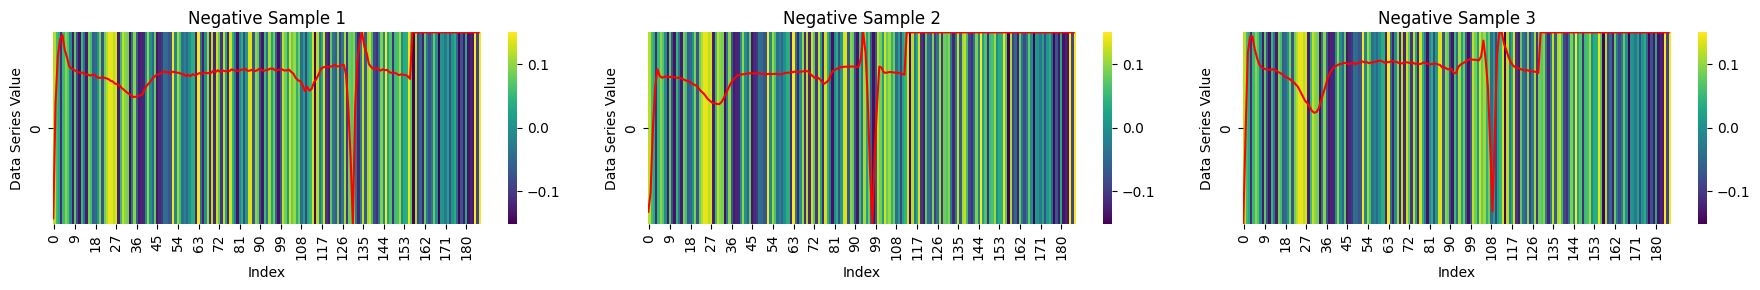

In [75]:
indices_class_0 = np.where(PTB_y_train.values == 0)[0]
indices_class_1 = np.where(PTB_y_train.values == 1)[0]
    
n_samples = 3  
sampled_indices_class_1 = np.random.choice(indices_class_1, size=n_samples, replace=False)
sampled_indices_class_0 = np.random.choice(indices_class_0, size =n_samples,replace = False)

X_negative = PTB_X_train.values[sampled_indices_class_0]
X_positive = PTB_X_train.values[sampled_indices_class_1]
input_layer_weights = model.layers[2].get_weights()[0][0][0]

fig, axs = plt.subplots(1, n_samples, figsize=(18, 3))  
for i, ax in enumerate(axs):
    sns.heatmap(np.array([input_layer_weights[:187]]), cmap='viridis', ax=ax)
    ax.plot(X_positive[i], color='red')
    
    ax.set_xlabel('Index')
    ax.set_ylabel('Data Series Value')
    ax.set_title(f'Positive Sample {i+1}') 

plt.tight_layout() 
plt.show()

fig, axs = plt.subplots(1, n_samples, figsize=(18, 3))  
for i, ax in enumerate(axs):
    sns.heatmap(np.array([input_layer_weights[:187]]), cmap='viridis', ax=ax)
    ax.plot(X_negative[i], color='red')
    
    ax.set_xlabel('Index')
    ax.set_ylabel('Data Series Value')
    ax.set_title(f'Negative Sample {i+1}')  

plt.tight_layout() 
plt.show()

# PART 2

## Q1

In [76]:
num_classes = 5
MIT_y_train_onehot = tf.keras.utils.to_categorical(MIT_y_train, num_classes)
MIT_y_test_onehot = tf.keras.utils.to_categorical(MIT_y_test, num_classes)
MIT_y_val_onehot = tf.keras.utils.to_categorical(MIT_y_val, num_classes)

In [77]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(5, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

input_shape = (187, 1)
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 2
mlp_units = [128]
dropout = 0.25
mlp_dropout = 0.25

bih_model =  build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
bih_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)


'''bih_model.fit(MIT_X_train, MIT_y_train_onehot, 
          batch_size=128, 
          epochs=10, 
          validation_data=(MIT_X_val, MIT_y_val_onehot), 
          callbacks=[early_stopping],
          class_weight=MIT_class_weight_dict)

bih_model.save('models/bih_model.keras')'''

bih_model = keras.models.load_model('models/bih_model.keras')


MIT_y_pred_onehot = bih_model.predict(MIT_X_test)


685/685 ━━━━━━━━━━━━━━━━━━━━ 99s 144ms/step


In [78]:
MIT_y_pred =  np.argmax(MIT_y_pred_onehot, axis=-1)
acc = balanced_accuracy_score(MIT_y_test, MIT_y_pred)
print('-'*65)
print(f'Test balanced accuracy (multiclass) = {round(acc * 100, 4)}%')
print('-'*65)

-----------------------------------------------------------------
Test balanced accuracy (multiclass) = 87.0376%
-----------------------------------------------------------------


In [79]:
def get_transformer_encoder_output(model, input_data):
    inputs = model.input
    transformer_encoder_layer = model.layers[15] 
    encoder_model = tf.keras.Model(inputs=inputs, outputs=transformer_encoder_layer.output)
    encoder_output = encoder_model.predict(input_data)
    return encoder_output


## Q2

In [80]:

def create_pairs(x, y):
    pairs = []
    labels = []

    n_classes = len(np.unique(y))
    class_indices = [np.where(y == i)[0] for i in range(n_classes)]

    for idx1 in range(int(len(x)/5)):
        x1 = x[idx1]
        label1 = y[idx1]
        
        idx2 = np.random.choice(class_indices[label1])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels.append(1)


        neg_label = np.random.choice([i for i in range(n_classes) if i != label1])
        idx2 = np.random.choice(class_indices[neg_label])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels.append(0)
    
    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs(MIT_X_train.values, MIT_y_train.astype(int).values)

In [81]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_embedding_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    outputs = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    return tf.keras.Model(inputs, outputs)

input_shape = (187, 1)
head_size = 256
num_heads = 4
ff_dim = 128
num_transformer_blocks = 2
dropout = 0.1


embedding_model = build_embedding_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)


def build_siamese_network(embedding_model, input_shape):
    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    embedding_a = embedding_model(input_a)
    embedding_b = embedding_model(input_b)

    merged = layers.Lambda(lambda tensors: tf.keras.backend.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])
    output = layers.Dense(1, activation="sigmoid")(merged)

    return tf.keras.Model(inputs=[input_a, input_b], outputs=output)


siamese_model = build_siamese_network(embedding_model, input_shape)
siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

'''siamese_model.fit([pairs[:, 0], pairs[:, 1]], labels, batch_size=64, epochs=30)

embedding_model.save('models/contrastive_model.keras')'''
embedding_model = keras.models.load_model('models/contrastive_model.keras')

Epoch 1/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.5168 - loss: 0.6972
Epoch 2/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6048 - loss: 0.6632
Epoch 3/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6221 - loss: 0.6532
Epoch 4/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.6280 - loss: 0.6472
Epoch 5/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6392 - loss: 0.6403
Epoch 6/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6369 - loss: 0.6419
Epoch 7/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6415 - loss: 0.6368
Epoch 8/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6471 - loss: 0.6360
Epoch 9/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.6450 - loss: 0.6332
Epoch 10/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.6473 - loss: 0.6321
Epoch 11/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.6482 - loss: 0.6315
Epoch 12/30
466/466 ━━━━━━━━━━━━━━━━━━━━ 

In [82]:
encoding_train = embedding_model.predict(MIT_X_train)
encoding_test = embedding_model.predict(MIT_X_test)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(encoding_train, MIT_y_train)
rf_pred = rf_classifier.predict(encoding_test)

acc = balanced_accuracy_score(MIT_y_test, rf_pred)
print('-'*65)
print(f'Test balanced accuracy (multiclass) = {round(acc * 100, 4)}%')
print('-'*65)


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 330s 142ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 98s 144ms/step
-----------------------------------------------------------------
Test balanced accuracy (multiclass) = 80.418%
-----------------------------------------------------------------


## Q3

In [153]:
## FIRST ENCODER PTB
umap_model = umap.UMAP(n_neighbors=50, min_dist=0.05, n_components=2, metric='manhattan', random_state=42)
df = pd.DataFrame(get_transformer_encoder_output(bih_model, PTB_X_train))
umap_result = umap_model.fit_transform(df)

310/310 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


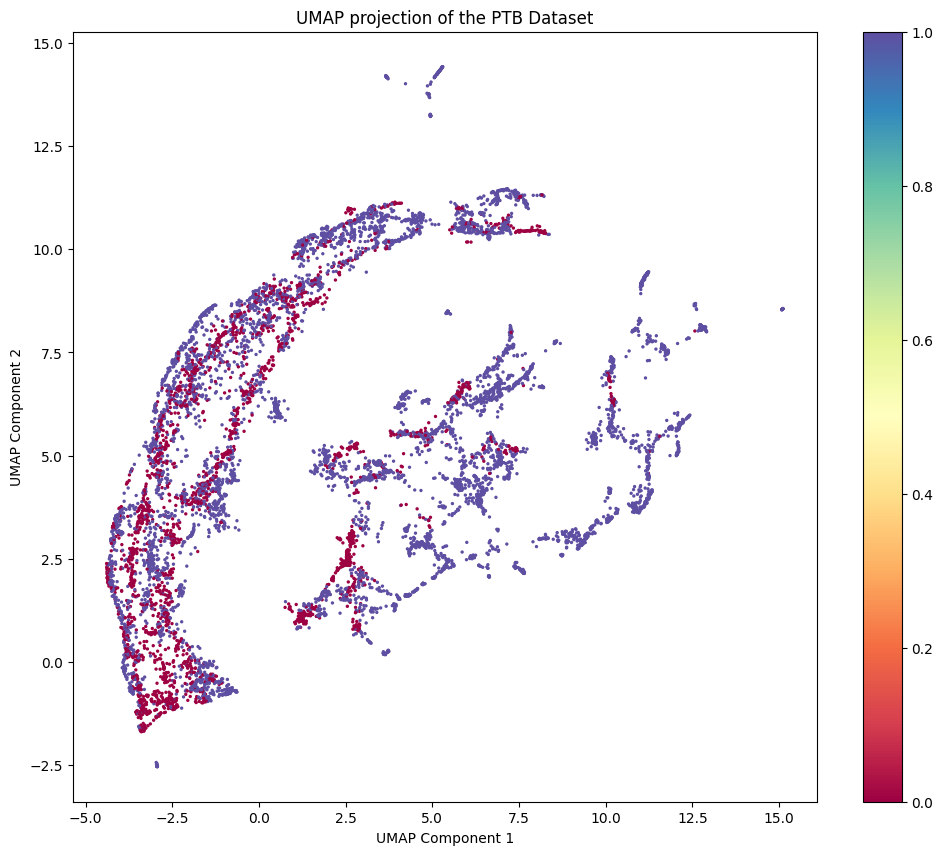

In [157]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=PTB_y_train, cmap='Spectral', s=2)
plt.colorbar(scatter)
plt.title('UMAP projection of the PTB Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [158]:
## SECOND ENCODER PTB
umap_model = umap.UMAP(n_neighbors=50, min_dist=0.05, n_components=2, metric='manhattan', random_state=42)
df = pd.DataFrame(embedding_model.predict(PTB_X_train))
umap_result = umap_model.fit_transform(df)

310/310 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


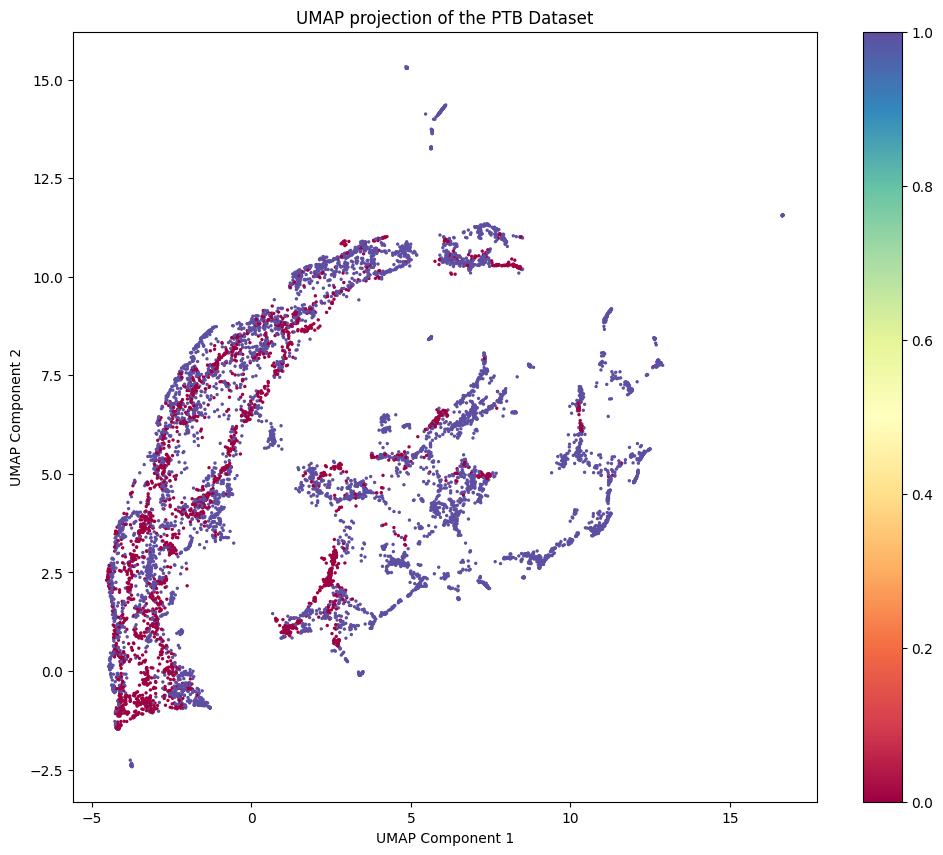

In [160]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=PTB_y_train, cmap='Spectral', s=2)
plt.colorbar(scatter)
plt.title('UMAP projection of the PTB Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [161]:
## FIRST ENCODER MIT
umap_model = umap.UMAP(n_neighbors=50, min_dist=0.05, n_components=2, metric='manhattan', random_state=42)
df = pd.DataFrame(get_transformer_encoder_output(bih_model, MIT_X_train))
umap_result = umap_model.fit_transform(df)

2326/2326 ━━━━━━━━━━━━━━━━━━━━ 352s 151ms/step


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


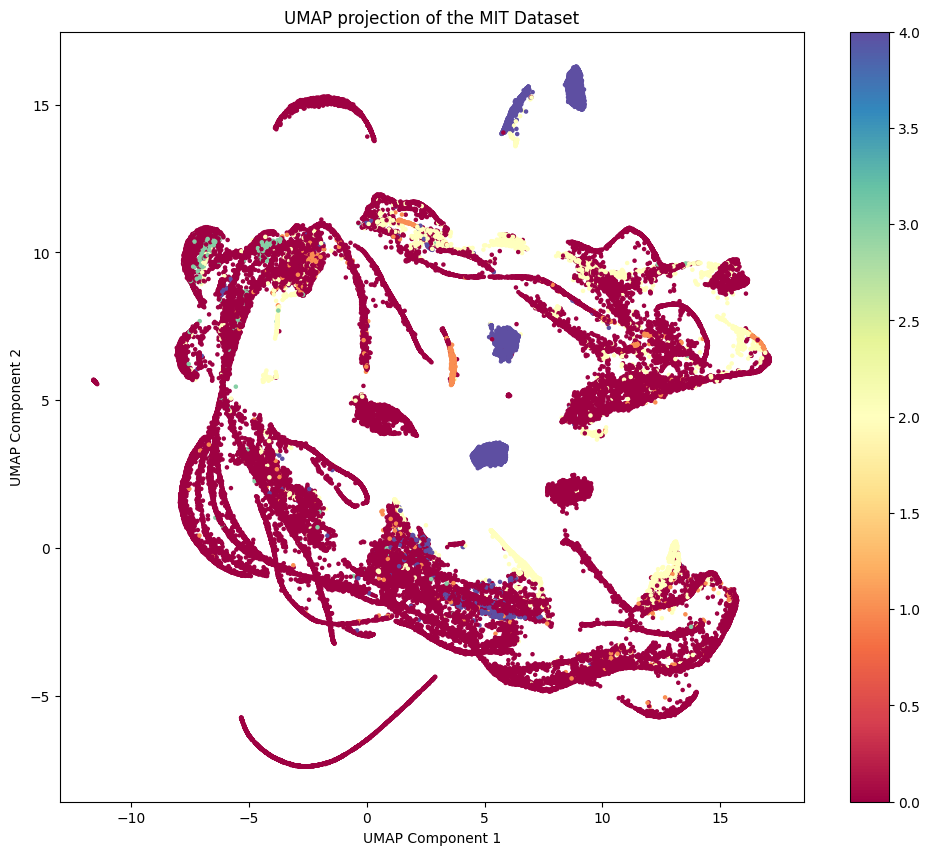

In [163]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=MIT_y_train, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the MIT Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [164]:
## SECOND ENCODER MIT
umap_model = umap.UMAP(n_neighbors=50, min_dist=0.05, n_components=2, metric='manhattan', random_state=42)
df = pd.DataFrame(embedding_model.predict(MIT_X_train))
umap_result = umap_model.fit_transform(df)

2326/2326 ━━━━━━━━━━━━━━━━━━━━ 340s 146ms/step


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


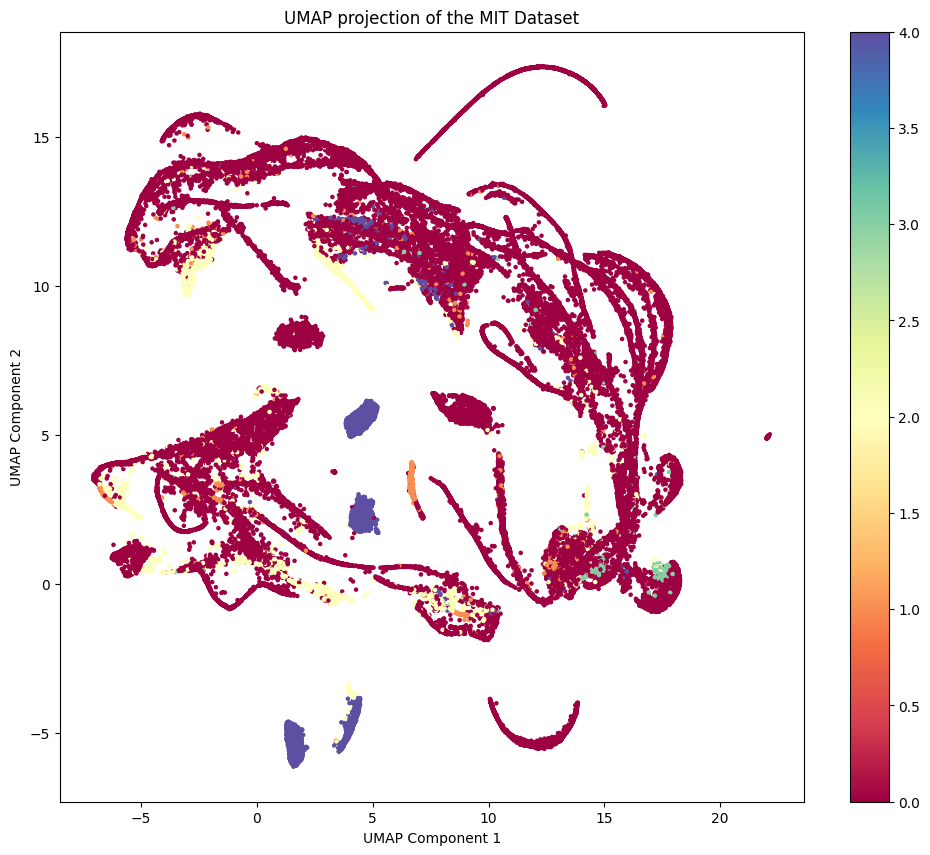

In [165]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=MIT_y_train, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the MIT Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Q4

### 1

In [ ]:
#FIRST ENCODER Q1 ON PTB + RANDOM FOREST

ptb_encoding_train = get_transformer_encoder_output(bih_model,PTB_X_train)
ptb_encoding_test = get_transformer_encoder_output(bih_model, PTB_X_test)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(ptb_encoding_train.squeeze(), PTB_y_train)
rf_pred = rf_classifier.predict(ptb_encoding_test.squeeze())
acc = balanced_accuracy_score(PTB_y_test, rf_pred)

print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)


# SECOND ENCODER ON PTB + RANDOM FOREST

ptb_encoding_train_2 = embedding_model.predict(PTB_X_train)
ptb_encoding_test_2 = embedding_model.predict(PTB_X_test)
rf_classifier_2 = RandomForestClassifier(random_state=42)
rf_classifier_2.fit(ptb_encoding_train_2, PTB_y_train)
rf_pred_2 = rf_classifier_2.predict(ptb_encoding_test_2)
acc_2 = balanced_accuracy_score(PTB_y_test, rf_pred_2)

print('-'*65)
print(f'Test balanced accuracy = {round(acc_2 * 100, 4)}%')
print('-'*65)


310/310 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step
-----------------------------------------------------------------
Test balanced accuracy = 95.2022%
-----------------------------------------------------------------
310/310 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step
-----------------------------------------------------------------
Test balanced accuracy = 95.2022%
-----------------------------------------------------------------


### 2A

In [ ]:
# FIRST ENCODER FULL MODEL
bih_model_clone = keras.models.clone_model(bih_model)
bih_model_clone.set_weights(bih_model.get_weights())
first_encoder_output = bih_model_clone.layers[15].output
first_encoder_model = keras.Model(inputs=bih_model_clone.input, outputs=first_encoder_output)
output_layer = Dense(1, activation='sigmoid')(first_encoder_output)
full_first_model = keras.Model(inputs=first_encoder_model.input, outputs=output_layer)

full_first_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
for layer in full_first_model.layers[:16]:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

'''full_first_model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=30, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          callbacks=[early_stopping],
          class_weight=PTB_class_weight_dict)
full_first_model.save('models/encoder1frozen.keras')'''

full_first_model = keras.models.load_model('models/encoder1frozen.keras')

PTB_y_pred = full_first_model.predict(PTB_X_test)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 385ms/step - accuracy: 0.6941 - loss: 0.6385 - val_accuracy: 0.7119 - val_loss: 0.5745
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 372ms/step - accuracy: 0.6964 - loss: 0.5718 - val_accuracy: 0.7216 - val_loss: 0.5455
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 374ms/step - accuracy: 0.6999 - loss: 0.5473 - val_accuracy: 0.7262 - val_loss: 0.5304
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 376ms/step - accuracy: 0.7095 - loss: 0.5324 - val_accuracy: 0.7394 - val_loss: 0.5108
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 375ms/step - accuracy: 0.7363 - loss: 0.5139 - val_accuracy: 0.7434 - val_loss: 0.5163
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 381ms/step - accuracy: 0.7220 - loss: 0.5141 - val_accuracy: 0.7480 - val_loss: 0.5094
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 377ms/step - accuracy: 0.7324 - loss: 0.5054 - val_accuracy: 0.7497 - val_loss: 0.5070
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 381ms/step - accuracy: 0.7386 - loss: 0

/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step
-----------------------------------------------------------------
Test balanced accuracy = 76.8016%
-----------------------------------------------------------------


In [ ]:
# SECOND ENCODER FULL MODEL
embedding_model_clone = keras.models.clone_model(embedding_model)
embedding_model_clone.set_weights(embedding_model.get_weights())

second_encoder_model = embedding_model_clone
output_layer = Dense(1, activation='sigmoid')(second_encoder_model.layers[-1].output)
full_second_model = keras.Model(second_encoder_model.input, output_layer)
full_second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for layer in full_second_model.layers[:16]:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

'''full_second_model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=30, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          callbacks=[early_stopping],
          class_weight=PTB_class_weight_dict)
full_second_model.save('models/encoder2frozen.keras')'''

full_second_model = keras.models.load_model('models/encoder2frozen.keras')

PTB_y_pred = full_second_model.predict(PTB_X_test)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 380ms/step - accuracy: 0.6751 - loss: 0.6748 - val_accuracy: 0.7239 - val_loss: 0.5680
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 380ms/step - accuracy: 0.7096 - loss: 0.5806 - val_accuracy: 0.7096 - val_loss: 0.5601
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 383ms/step - accuracy: 0.7121 - loss: 0.5433 - val_accuracy: 0.7314 - val_loss: 0.5324
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 380ms/step - accuracy: 0.7173 - loss: 0.5317 - val_accuracy: 0.7423 - val_loss: 0.5141
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 390ms/step - accuracy: 0.7405 - loss: 0.5105 - val_accuracy: 0.7400 - val_loss: 0.5173
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 373ms/step - accuracy: 0.7349 - loss: 0.5050 - val_accuracy: 0.7440 - val_loss: 0.5185
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - accuracy: 0.7329 - loss: 0.5038 - val_accuracy: 0.7497 - val_loss: 0.5045
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 375ms/step - accuracy: 0.7423 - loss: 0

/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step
-----------------------------------------------------------------
Test balanced accuracy = 77.6152%
-----------------------------------------------------------------


### 2B

In [ ]:
# ENCODER 1 FULL TRAINABLE

bih_model_clone = keras.models.clone_model(bih_model)
bih_model_clone.set_weights(bih_model.get_weights())
first_encoder_output = bih_model_clone.layers[15].output
first_encoder_model = keras.Model(inputs=bih_model_clone.input, outputs=first_encoder_output)
output_layer = Dense(1, activation='sigmoid')(first_encoder_output)
full_first_model = keras.Model(inputs=first_encoder_model.input, outputs=output_layer)

full_first_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

'''full_first_model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=30, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          callbacks=[early_stopping],
          class_weight=PTB_class_weight_dict)
full_first_model.save('models/encoder1fulltrain.keras')'''

full_first_model = keras.models.load_model('models/encoder1fulltrain.keras')

PTB_y_pred = full_first_model.predict(PTB_X_test)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)


Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 119s 753ms/step - accuracy: 0.5759 - loss: 0.6630 - val_accuracy: 0.6575 - val_loss: 0.6121
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 747ms/step - accuracy: 0.6868 - loss: 0.5803 - val_accuracy: 0.7211 - val_loss: 0.5501
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.7065 - loss: 0.5480 - val_accuracy: 0.7428 - val_loss: 0.5157
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7215 - loss: 0.5279 - val_accuracy: 0.7360 - val_loss: 0.5373
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 744ms/step - accuracy: 0.7291 - loss: 0.5211 - val_accuracy: 0.7400 - val_loss: 0.5239
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 750ms/step - accuracy: 0.7298 - loss: 0.5098 - val_accuracy: 0.7468 - val_loss: 0.5129
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7365 - loss: 0.5003 - val_accuracy: 0.7623 - val_loss: 0.4925
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 743ms/step - accuracy: 0.7358 -

In [ ]:
# SECOND ENCODER FULL TRAINABLE
embedding_model_clone = keras.models.clone_model(embedding_model)
embedding_model_clone.set_weights(embedding_model.get_weights())

second_encoder_model = embedding_model_clone
output_layer = Dense(1, activation='sigmoid')(second_encoder_model.layers[-1].output)
full_second_model = keras.Model(second_encoder_model.input, output_layer)
full_second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

'''full_second_model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=30, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          callbacks=[early_stopping],
          class_weight=PTB_class_weight_dict)
full_second_model.save('models/encoder2fulltrain.keras')'''

full_second_model = keras.models.load_model('models/encoder2fulltrain.keras')

PTB_y_pred = full_second_model.predict(PTB_X_test)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 118s 748ms/step - accuracy: 0.6210 - loss: 0.6900 - val_accuracy: 0.6861 - val_loss: 0.5863
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.6781 - loss: 0.5848 - val_accuracy: 0.7279 - val_loss: 0.5353
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 748ms/step - accuracy: 0.7116 - loss: 0.5532 - val_accuracy: 0.7417 - val_loss: 0.5242
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 749ms/step - accuracy: 0.7281 - loss: 0.5318 - val_accuracy: 0.7394 - val_loss: 0.5290
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 748ms/step - accuracy: 0.7263 - loss: 0.5293 - val_accuracy: 0.7468 - val_loss: 0.5225
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 120s 775ms/step - accuracy: 0.7417 - loss: 0.5051 - val_accuracy: 0.7532 - val_loss: 0.5085
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 117s 754ms/step - accuracy: 0.7429 - loss: 0.5085 - val_accuracy: 0.7543 - val_loss: 0.5057
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 749ms/step - accuracy: 0.7445 -

### 2C

In [ ]:
# ENCODER 1 FIRST PRETRAIN, UNFREEEZE, FINETUNE

full_first_model = keras.models.load_model('models/encoder1frozen.keras')
for layer in full_first_model.layers[:16]:
    layer.trainable = True

full_first_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

'''full_first_model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=20, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          class_weight=PTB_class_weight_dict)


full_first_model.save('models/encoder1_fancy.keras')'''

full_first_model = keras.models.load_model('models/encoder1_fancy.keras')

PTB_y_pred = full_first_model.predict(PTB_X_test)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 121s 761ms/step - accuracy: 0.7631 - loss: 0.4641 - val_accuracy: 0.7743 - val_loss: 0.4689
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7560 - loss: 0.4756 - val_accuracy: 0.7732 - val_loss: 0.4706
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7519 - loss: 0.4728 - val_accuracy: 0.7715 - val_loss: 0.4720
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7592 - loss: 0.4622 - val_accuracy: 0.7703 - val_loss: 0.4730
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7533 - loss: 0.4716 - val_accuracy: 0.7698 - val_loss: 0.4740
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 744ms/step - accuracy: 0.7555 - loss: 0.4638 - val_accuracy: 0.7726 - val_loss: 0.4747
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 744ms/step - accuracy: 0.7620 - loss: 0.4629 - val_accuracy: 0.7715 - val_loss: 0.4753
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.7613 -

In [ ]:
# SECOND ENCODER FIRST PRETRAIN, UNFREEEZE, FINETUNE

full_second_model = keras.models.load_model('models/encoder2frozen.keras')

for layer in full_second_model.layers[:16]:
    layer.trainable = True

full_second_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

'''full_first_model.fit(PTB_X_train.values, PTB_y_train.values, 
          batch_size=64, 
          epochs=20, 
          validation_data=(PTB_X_val.values, PTB_y_val.values), 
          class_weight=PTB_class_weight_dict)

full_second_model.save('models/encoder2_fancy.keras')'''

full_second_model = keras.models.load_model('models/encoder2_fancy.keras')

PTB_y_pred = full_second_model.predict(PTB_X_test)
PTB_y_pred = (PTB_y_pred >= 0.5).astype(int)
acc = balanced_accuracy_score(PTB_y_test, PTB_y_pred)
print('-'*65)
print(f'Test balanced accuracy = {round(acc * 100, 4)}%')
print('-'*65)

Epoch 1/20


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


155/155 ━━━━━━━━━━━━━━━━━━━━ 118s 748ms/step - accuracy: 0.7578 - loss: 0.4671 - val_accuracy: 0.7640 - val_loss: 0.4788
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.7621 - loss: 0.4626 - val_accuracy: 0.7640 - val_loss: 0.4791
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 746ms/step - accuracy: 0.7610 - loss: 0.4613 - val_accuracy: 0.7640 - val_loss: 0.4788
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 742ms/step - accuracy: 0.7629 - loss: 0.4607 - val_accuracy: 0.7640 - val_loss: 0.4789
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 743ms/step - accuracy: 0.7578 - loss: 0.4676 - val_accuracy: 0.7646 - val_loss: 0.4787
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.7536 - loss: 0.4649 - val_accuracy: 0.7646 - val_loss: 0.4786
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.7543 - loss: 0.4625 - val_accuracy: 0.7646 - val_loss: 0.4786
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 115s 744ms/step - accuracy: 0.7565 - loss: 0.46

/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 70 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step
-----------------------------------------------------------------
Test balanced accuracy = 77.6152%
-----------------------------------------------------------------
